# Metody Obliczeniowe w Nauce i Technice
## Laboratorium 11 - Generatory Liczb Losowych
### Albert Gierlach

Użyta wersja pythona:

* Python 3.8.3 64bit

Użyte biblioteki:

* numpy 1.18.2
* scipy 1.4.1
* matplotlib 3.2.1

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; 
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
from numpy.random import default_rng
from scipy.special import gammaincc
import random
import functools
import matplotlib as mtplt
from matplotlib import pyplot as plt
from scipy.stats import norm, shapiro

mtplt.rcParams['figure.figsize'] = [14, 7] # plots size

#### 1. Testowanie generatorów liczb losowych
Na początku zaimplementowałem funkcję, która przyjmuje ilość liczb do wygenerowania oraz generator, który ma być użyty do generacji. Funkcja realizuje także rysowanie histogramu, sprawdzanie dla ilu liczb w sekwencji jest spełniona zależność \\(x_i < x_{i+1}\\) oraz przeprowadzenie jednego z testów na losowość wygenerowanej sekwencji liczb.
Wybranym testem na losowość został 'Approximate Entropy Test'. Celem tego testu jest porównanie częstotliwości zachodzenia na siebie sąsiednich sekwencji o zadanej długości. Test jest rozważany jako pozytywny gdy obliczona p-wartość jest większa bądź równa 0.01. Algorytm jest dość wymagający obliczeniowo, jego złożoność wynosi \\(\approx O(n^3)\\)

In [3]:
def approximate_entropy_test(seq, m=2, n=3):
    def to_number_from_m_bits(arr):
        return np.packbits(arr, axis=-1) >> (8 - m)

    def to_number_from_m_plus_bits(arr):
        return np.packbits(arr, axis=-1) >> (7 - m)

    seq = list(map(lambda x: int(x), seq))
    seq_m = seq + seq[:m-1]
    seq_m_plus = seq + seq[:m]
    C_m = np.zeros(to_number_from_m_bits(np.ones(m, dtype=np.int8)) + 1)
    C_m_plus = np.zeros(to_number_from_m_plus_bits(np.ones(m + 1, dtype=np.int8)) + 1)

    for i in range(n):
        C_m[to_number_from_m_bits(seq_m[i: i+m])] += 1
        C_m_plus[to_number_from_m_plus_bits(seq_m_plus[i: i+m+1])] += 1

    C_m, C_m_plus = C_m / n, C_m_plus / n
    phi_m = 0
    for c in C_m:
        if c != 0:
            phi_m += c * np.log(c)

    phi_m_plus = 0
    for c in C_m_plus:
        if c != 0:
            phi_m_plus += c * np.log(c)

    ap_en = phi_m - phi_m_plus
    xsi = 2 * n * (np.log(2) - ap_en)
    p_value = gammaincc(2 ** (m - 1), xsi / 2)

    return p_value >= 0.01

In [4]:
def test_generator(n, generator, title):
    BUCKETS_NUM = 10
    rand_nums = generator(n)
    prev = sum(j > i for i, j in zip(rand_nums, rand_nums[1:]))
    test_result = approximate_entropy_test(rand_nums)

    plt.hist(rand_nums, BUCKETS_NUM, facecolor='blue', alpha=0.5, ec='black')
    plt.title("{} - {} probek".format(title, n))
    plt.ylabel("Ilosc wystapien")
    plt.xlabel("x")
    plt.show()
    
    print("[{}] x_i < x_(i+1) is satisfied for {} numbers ({}%)".format(title, prev, round(prev * 100 / n)))
    print("Approximate Entropy Test: Sequence is {}\n\n".format("random" if test_result else "not random"))

Następnie uruchomiłem powyższą funkcję dla trzech różnych wartości n (10, 1000, 5000) oraz dla różnych generatorów (Mersenne Twister i PCG64).

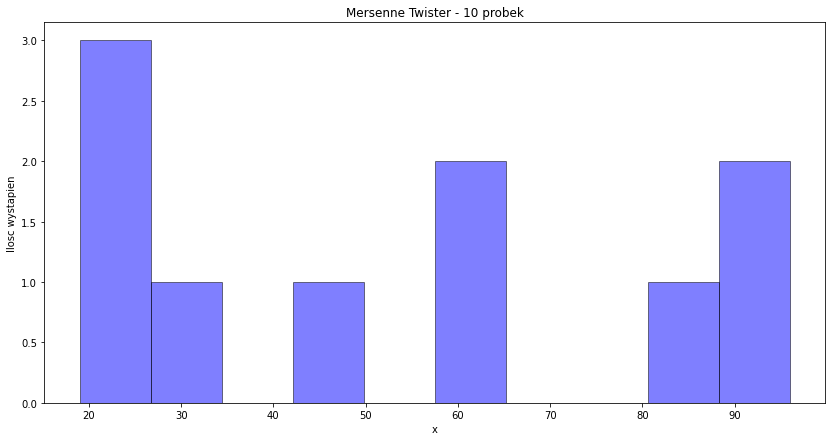

[Mersenne Twister] x_i < x_(i+1) is satisfied for 5 numbers (50%)
Approximate Entropy Test: Sequence is random




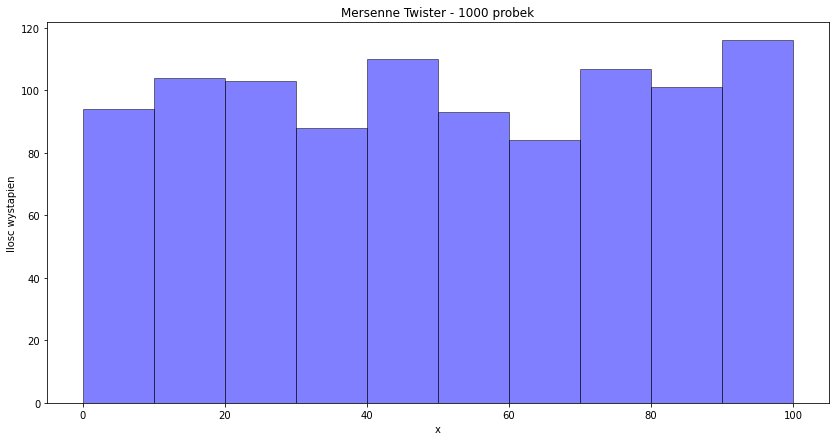

[Mersenne Twister] x_i < x_(i+1) is satisfied for 503 numbers (50%)
Approximate Entropy Test: Sequence is random




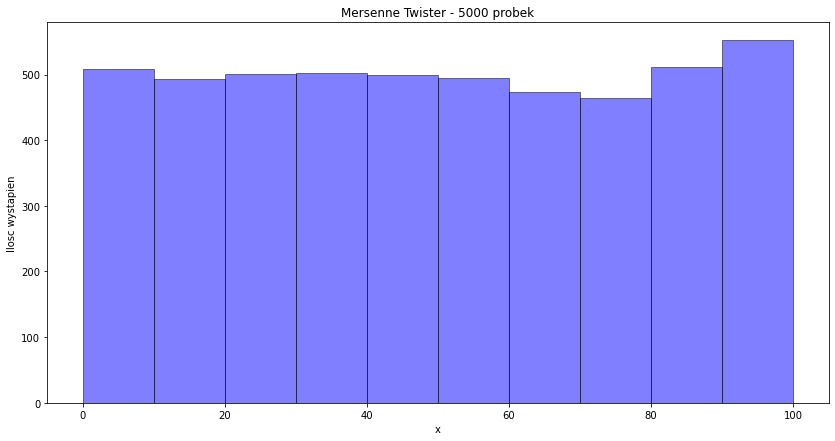

[Mersenne Twister] x_i < x_(i+1) is satisfied for 2485 numbers (50%)
Approximate Entropy Test: Sequence is random




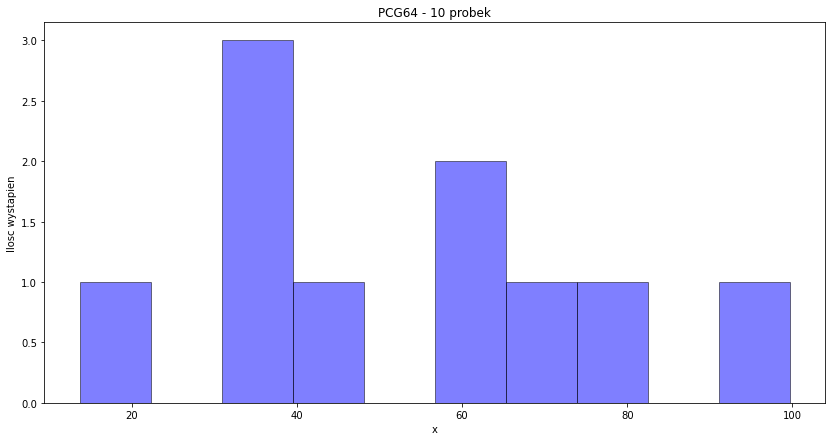

[PCG64] x_i < x_(i+1) is satisfied for 4 numbers (40.0%)
Approximate Entropy Test: Sequence is random




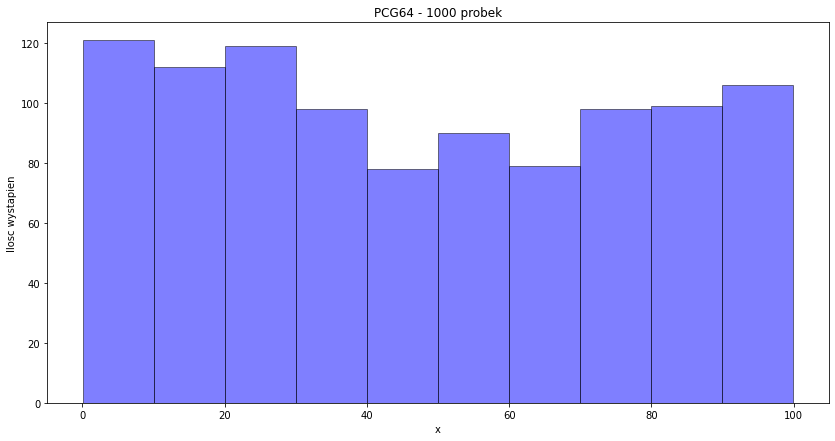

[PCG64] x_i < x_(i+1) is satisfied for 495 numbers (50.0%)
Approximate Entropy Test: Sequence is random




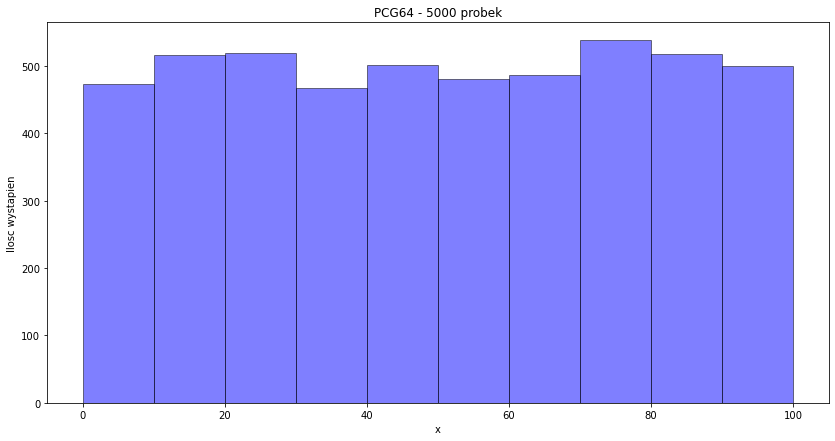

[PCG64] x_i < x_(i+1) is satisfied for 2516 numbers (50.0%)
Approximate Entropy Test: Sequence is random




In [5]:
INTERVAL_BEGIN = 0
INTERVAL_END = 100
n = [10, 1000, 5000]

gens = [
    ("Mersenne Twister", functools.partial(lambda x: [random.randint(INTERVAL_BEGIN, INTERVAL_END) for _ in range(x)])),
    ("PCG64", functools.partial(default_rng().uniform, INTERVAL_BEGIN, INTERVAL_END))
]

for title, gen in gens:
    for nn in n:
        test_generator(nn, gen, title)

Powyższe wykresy pokazują różnice pomiędzy generatorem Mersenne Twister oraz PCG64. Różnice w przedstawionych wykresach nie są zbyt spore. Możemy zaobserwować, że wraz ze wzrostem n (liczby próbek) generator PCG64 daje lepszy rozkład wyników - wyglądają one lepiej rozdystrybuowane na całym przedziale.

W przypadku idealnego generatora zależność \\(x_i < x_{i+1}\\) powinna być spełniona dla 50% liczb. Wtedy nie można przewidzieć czy następna wygenerowana liczba jest większa czy mniejsza. Przy prawdopodobieństwie 90% można by przewidywać, że każda następna wygenerowana liczba jest mniejsza od poprzedniej, co znacznie zawęża dziedzine losowości.

#### 2. Generowanie liczb z rozkładu normalnego
Na początku zaimplementowałem klasę realizującą generator liczb losowych pochodzących z rozkładu normalnego za pomocą metody Boksa-Mullera. W implementacji uwzględniłem odchylenie standardowe oraz wartość oczekiwaną. Implementacja prezentuje się następująco:

In [6]:
class BoxMullerGenerator:
    def __init__(self, mu=0, sig=1):
        self.sigma = sig  # standard deviation
        self.mu = mu  # expected value
        self.generateNewPair = False
        self.x1 = 0
        self.x2 = 0

    def get_sigma(self):
        return self.sigma

    def get_mu(self):
        return self.mu

    def compute_return(self, val):
        return (val * self.sigma) + self.mu

    def generate(self):
        self.generateNewPair = not self.generateNewPair

        if not self.generateNewPair:
            return self.compute_return(self.x2)

        u1, u2 = random.random(), random.random()
        self.x1 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
        self.x2 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)

        return self.compute_return(self.x1)

Następnie stworzyłem funkcję, która rysuje histogram dla n wylosowanych liczb oraz na tym samym wykresie rysuje krzywą Gaussa o zadanych parametrach. Na końcu funkcja stwierdza (za pomocą testu Shapiro-Wilka) czy dane mogą pochodzić z rozkładu normalnego.

In [7]:
def test_generator_box_muller(n, mu=0, sig=1):
    gen = BoxMullerGenerator(mu, sig)
    nums = [gen.generate() for _ in range(n)]

    plt.hist(nums, 10, facecolor='blue', alpha=0.5, ec='black', density=True)
    plt.title(r"Box-Muller generator - {} samples $(\mu={}, \sigma={})$".format(n, mu, sig))
    plt.ylabel("Frequency of occurrences")
    plt.xlabel("x")

    x_axis = np.linspace(min(nums)-5, max(nums)+5, 1000)
    plt.plot(x_axis, norm.pdf(x_axis, mu, sig), c='red', linestyle='--')

    plt.show()

    _, p = shapiro(nums)
    alpha = 0.05
    if p > alpha:
        print("Hypothesis zero accepted - data is from a normal distribution")
    else:
        print("Hypothesis zero rejected - data is NOT from a normal distribution")
        
    print("\n\n")

Pozostało przetestować implementacje. W tym celu wykonałem trzy testy dla 10, 1000 i 5000 próbkach dla \\(\mu=0, \sigma=1\\) oraz jeden dodatkowy test dla 5000 próbek oraz \\(\mu=50, \sigma=15\\) 

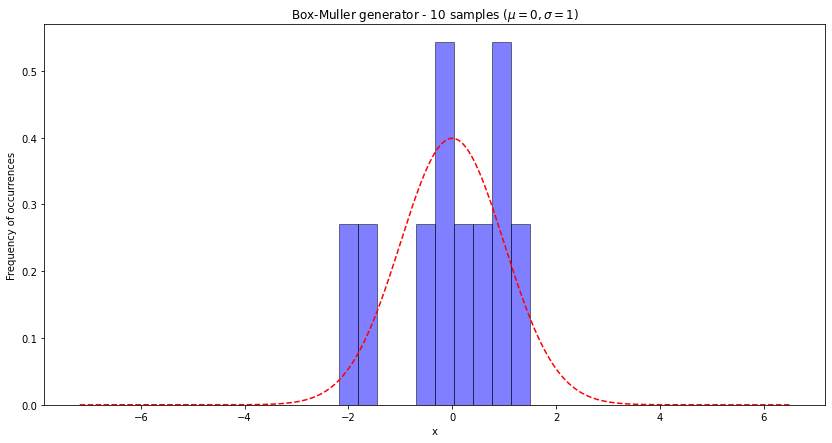

Hypothesis zero accepted - data is from a normal distribution





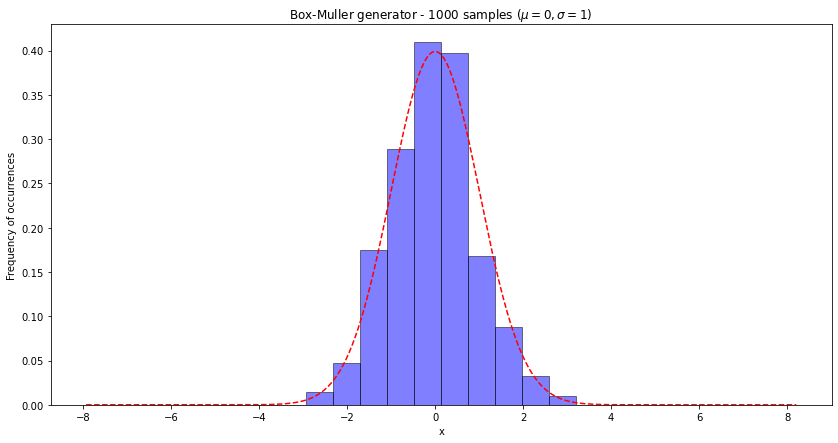

Hypothesis zero accepted - data is from a normal distribution





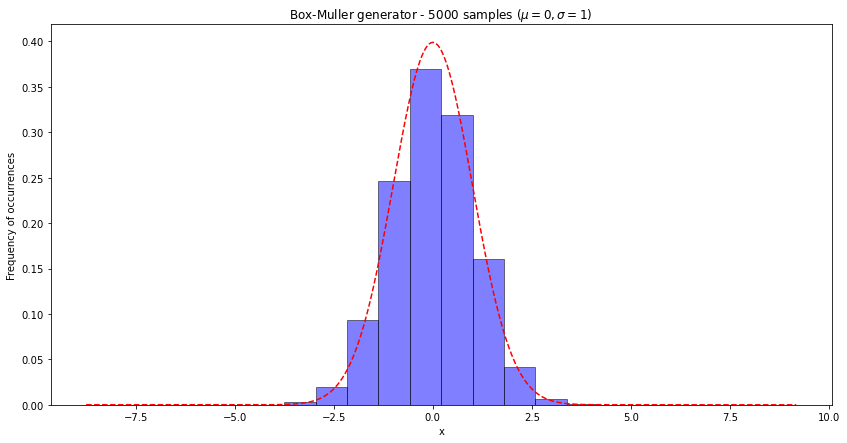

Hypothesis zero accepted - data is from a normal distribution





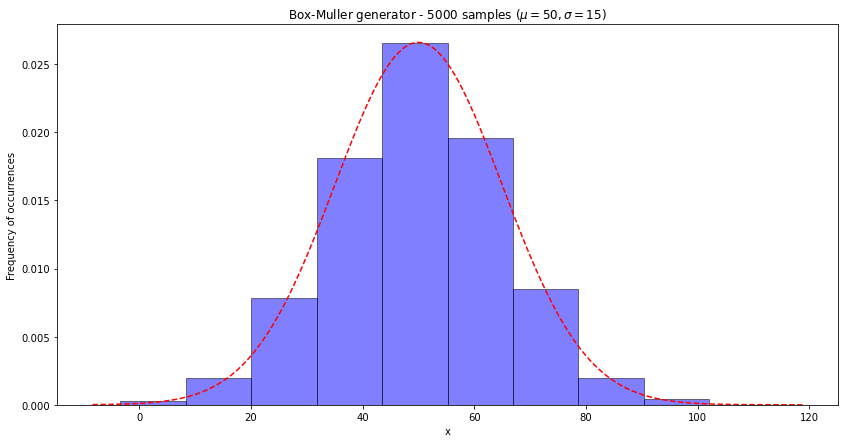

Hypothesis zero accepted - data is from a normal distribution





In [8]:
n = [10, 1000, 5000]

for nn in n:
    test_generator_box_muller(nn)

test_generator_box_muller(5000, 50, 15)

Powyższe przykłady prezentują jak rozkładają się wartości generowane generatorem Boxa-Mullera. Wykresy ilustrują, że dane przypuszczalnie pochodzą z rozkładu normalnego, a po użyciu testu Shapiro-Wilka mamy już pewność.

#### 3. Metoda Monte Carlo
Metoda rozwiązania jest bardzo prosta. Mamy kwadrat 1x1 oraz koło o promieniu 0.5. Środki obu figur znajdują się w punkcie (0, 0). Wzór na pole koła wyraża się następująco: \\(P = \pi * (\frac{1}{2}^2) = \frac{\pi}{4}\\). Pole koła może być także obliczone za pomocą losowania punktów i umieszczania ich w jednostkowym kwadracie. Wtedy pole koła wyrazi się wzorem \\(P_{est} = \frac{liczba\ punktów\ wewnątrz\ koła}{liczba\ wszystkich\ punktów} \\). Przyrównując oba wzory do siebie otrzymujemy wzór \\(\pi = 4 * P_{est}\\). Posiadając tą wiedzę przystąpiłem do implementacji. Funkcja losuje n punktów, rysuje okrąg i punkty.

In [9]:
def estimate_pi(n):
    x = np.random.uniform(-1.0, 1.0, n)
    y = np.random.uniform(-1.0, 1.0, n)
    d = np.square(x) + np.square(y)
    q = (d <= 1)  # n-element list with booleans indicating if point is in circle or not

    if n < 30000 and not n % 3000:
        bounds = [-1.0, 1.0]

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        ax.plot(x[q], y[q], '.', color='green')
        ax.plot(x[np.logical_not(q)], y[np.logical_not(q)], '.', color='red')


        circ = plt.Circle((0.0, 0.0), radius=1, color='gray', fill=False, label='circle')
        ax.add_patch(circ)
        ax.set_aspect("equal")

        plt.title(r"Monte Carlo: $\pi$ estimation ({} points)".format(n))
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim(bounds)
        plt.ylim(bounds)
        plt.show()

    return 4 * (q.sum() / len(q))

Następnie zaimplementowałem funkcjonalność pozwalającą sprawdzić jak zmieniał się błąd w zależności od liczby losowanych punktów.

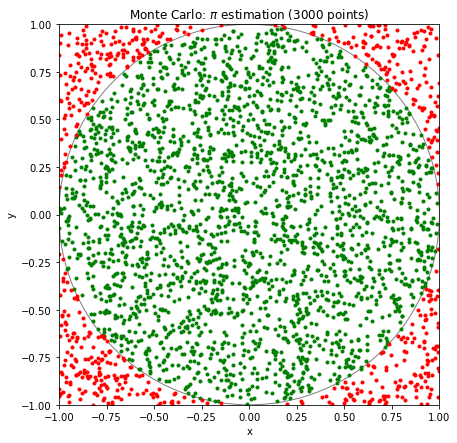

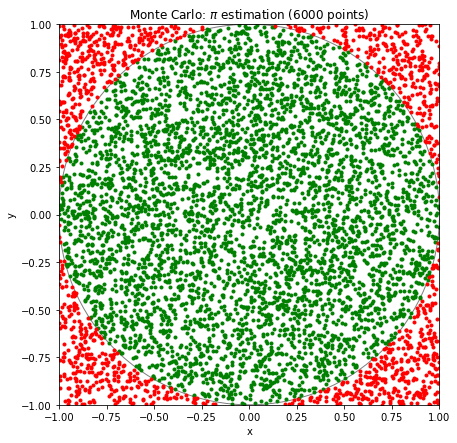

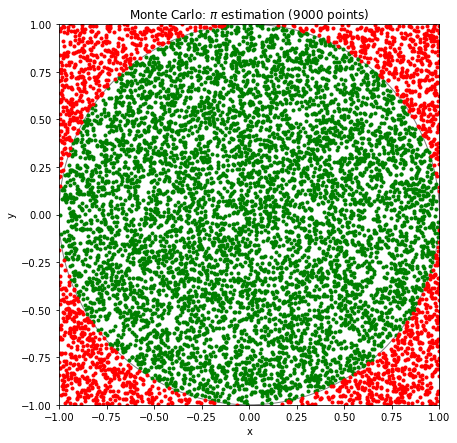

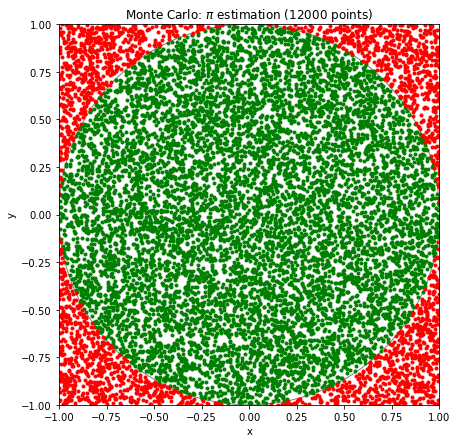

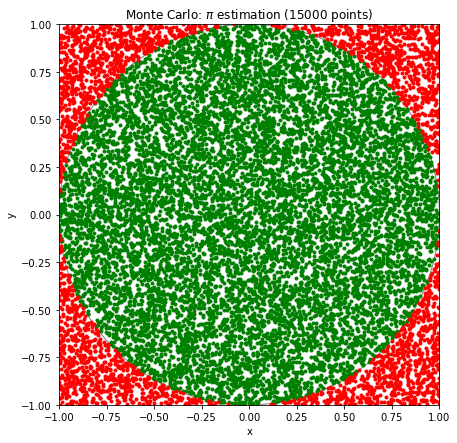

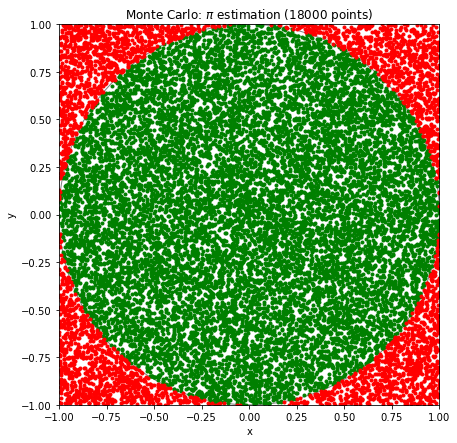

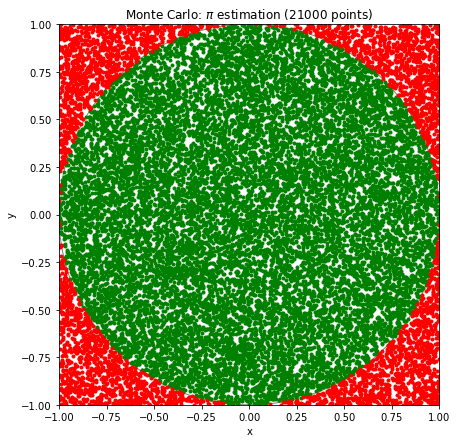

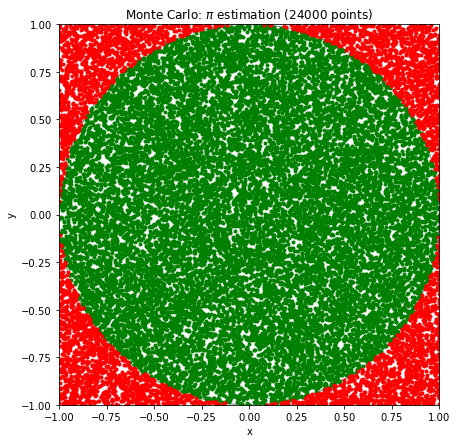

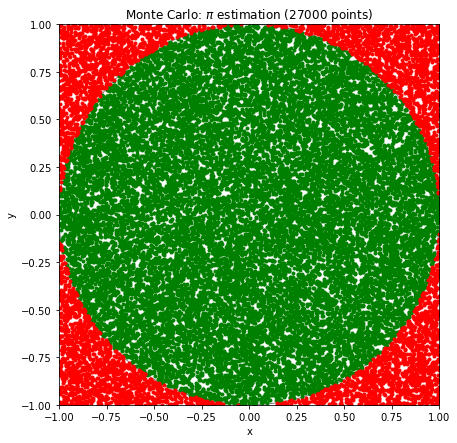

In [10]:
n = [i * 500 for i in range(1, 500)]
computed_pi = [estimate_pi(nn) for i, nn in enumerate(n)]
errors = list(map(lambda x: np.fabs(x - np.pi), computed_pi))

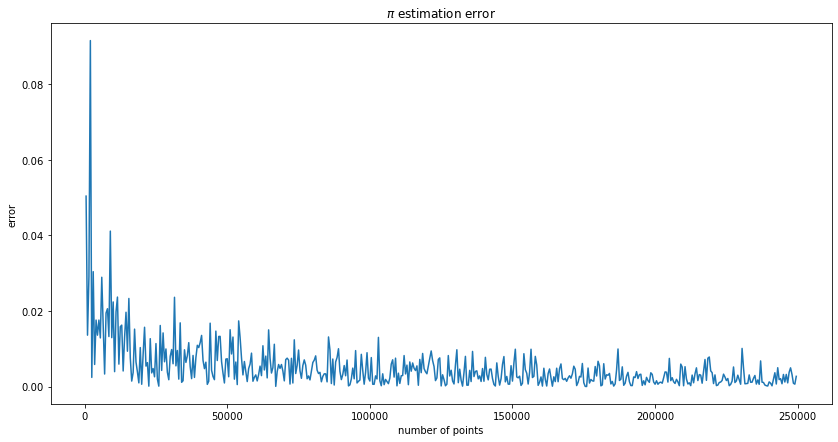

np.pi              : 3.141592653589793
best monte carlo pi: 3.141590909090909
error              : 1.7444988840153997e-06


In [11]:
plt.plot(n, errors)
plt.title(r"$\pi$ estimation error")
plt.ylabel("error")
plt.xlabel("number of points")
plt.show()

print("np.pi              : {}".format(np.pi))
print("best monte carlo pi: {}".format(computed_pi[errors.index(min(errors))]))
print("error              : {}".format(min(errors)))

Przeprowadzone doświadczenie pokazuje, że za pomocą metod statystycznych można wyznaczać stałe matematyczne z dobrą dokładnością. Błąd z jakim jest przybliżana stała maleje wraz ze wzrostem liczby punktów, a po przekroczeniu 150000 punktów oscyluje w granicach jednej setnej.